In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import open3d as o3d
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


In [2]:
attr = ['x','y', 'z', 'nx','ny', 'nz', 'diffuse_red', 'diffuse_green', 'diffuse_blue', 'class', 'detection']

In [3]:
path = "./ply/albert.ply"
pd1 = np.loadtxt(path, delimiter=" ", skiprows=15)
df = pd.DataFrame(pd1)
df.columns = attr

## show some points where the y threshold is set to some num

(array([17390.,  2678.,  1203.,   914.,   771.,   389.,   425.,   303.,
          265.,   296.]),
 array([2.9634 , 3.37732, 3.79124, 4.20516, 4.61908, 5.033  , 5.44692,
        5.86084, 6.27476, 6.68868, 7.1026 ]),
 <a list of 10 Patch objects>)

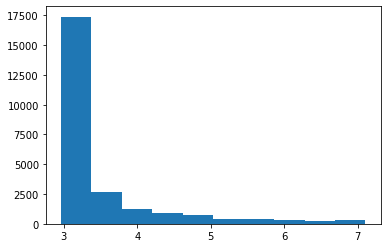

In [4]:
def reject_outliers(data, m=1):
    return abs(data - np.mean(data)) < m * np.std(data)
plt.hist(df['y'][reject_outliers(df['y'], m=.5)])

In [5]:
ythresh = 3
# mask = reject_outliers(df['y'])
mask = reject_outliers(df['x']) & reject_outliers(df['z'])
df1 = df.loc[mask]
# print(f"num pts of just albert {len(df1)}")
df1 = df1.loc[df1['y']<3]
print(f"num pts of just albert {len(df1)}")

num pts of just albert 231000


In [6]:
def write_ply(filename, df):
    header = f'''ply 
    format ascii 1.0
    element vertex {len(df)}
    property float x
    property float y
    property float z
    property float nx
    property float ny
    property float nz
    property uchar diffuse_red
    property uchar diffuse_green
    property uchar diffuse_blue
    property uchar class
    property uchar detection
    end_header
    '''
    with open(filename, "w+") as p:
        p.write(header)
        for i in df1.iterrows():
            p.write(f"{i[1]['x']} {i[1]['y']} {i[1]['z']} {i[1]['nx']} {i[1]['ny']} {i[1]['nz']} {int(i[1]['diffuse_red'])} {int(i[1]['diffuse_green'])} {int(i[1]['diffuse_blue'])} {int(i[1]['class'])} {int(i[1]['detection'])} \n")

In [7]:
#write_ply("./ply/just_albert.ply", df1)

In [8]:
# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("./ply/just_albert.ply")
# mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame()
# o3d.visualization.draw_geometries([pcd_load])

# now try to overlay the pts on the image

In [9]:
img = mpimg.imread('./ply/albert.jpg')
w,h = img.shape[1], img.shape[0]
print(f"size {w}, {h} picture")

size 3024, 4032 picture


In [10]:
# so now I scale everything to match the image size

x scale range 0.1311, 4.0943, 3.9631999999999996, to 3024
z scale range -1.803, 2.3351, 4.1381, to 4032


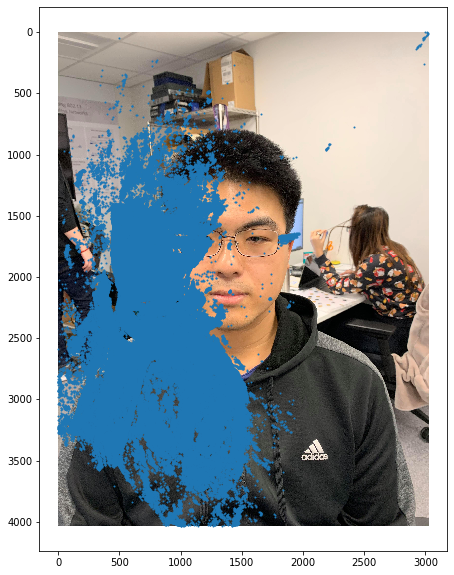

In [11]:
x_min, x_max = min(df1['x']), max(df1['x'])
z_min, z_max = min(df1['z']), max(df1['z'])
print(f"x scale range {x_min}, {x_max}, {x_max-x_min}, to {w}")
print(f"z scale range {z_min}, {z_max}, {z_max-z_min}, to {h}")

x_trans = np.interp(df1['x'], (x_min, x_max), (0, w-1))
y_trans = -1 * np.interp(df1['z'], (z_min, z_max), (0, h-1)) + h


plt.figure(figsize=(10,10))
plt.imshow(img)
plt.scatter( x_trans, y_trans , s=1)

In [12]:
img_mask = np.zeros((h, w, 3))
img_mask[y_trans.astype(int)-1, x_trans.astype(int)-1] = 1
# img_mask[y_trans.astype(int)-1, x_trans.astype(int)-1] = [0,0,0]

In [13]:
img_mask[3189,707]

array([0., 0., 0.])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


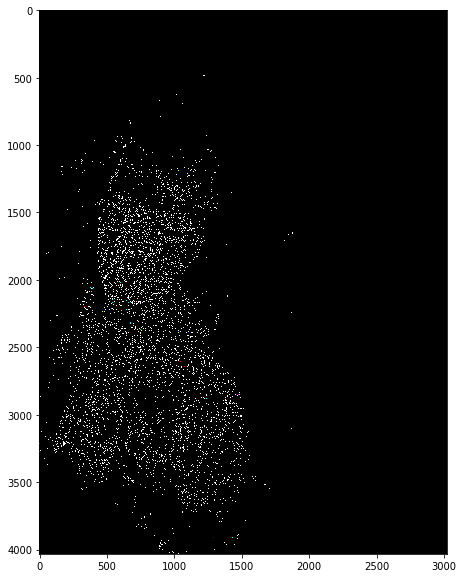

In [14]:
s = img * img_mask
plt.figure(figsize=(10,10))
plt.imshow(s)

# Use grabcut for foreground obj segmentation

In [18]:
import cv2 as cv

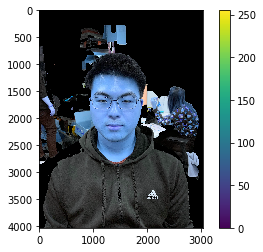

(<matplotlib.image.AxesImage at 0x7f95f2c8bdd8>,
 None)

In [36]:
from matplotlib import pyplot as plt

img = cv.imread('./ply/albert.jpg') # BGR for some freaking reason
# img = np.flip(img,axis=2)
mask = np.zeros(img.shape[:2],np.uint8)

# img by a random ass rectangle
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

x_sam, y_sam = np.random.choice(x_trans, size=10000), np.random.choice(y_trans, size=10000)
corner1_X, corner1_Y = int(min(x_sam)), int(min(y_sam))
corner2_X, corner2_Y = int(max(x_sam)), int(max(y_sam))
rect = (corner1_X, corner1_Y, corner2_X, corner2_Y) # dynamically pick box next time
cv.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img1 = img*mask2[:,:,np.newaxis]
plt.imshow(img1),plt.colorbar(),plt.show()

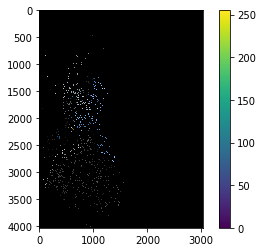

(<matplotlib.image.AxesImage at 0x7f95f58d8f60>,
 None)

In [24]:
# # second pass with the mask
# mask[y_trans.astype(int)-1, x_trans.astype(int)-1] = 1
# # mask[newmask == 255] = 1
# mask, bgdModel, fgdModel = cv.grabCut(img,mask,None,bgdModel,fgdModel,5,cv.GC_INIT_WITH_MASK)
# mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
# img = img*mask[:,:,np.newaxis]
# plt.imshow(img),plt.colorbar(),plt.show()

In [52]:
np.unique(mask) # 0 - sure forground, 2- maybe fg, 3- background

array([0, 2, 3], dtype=uint8)

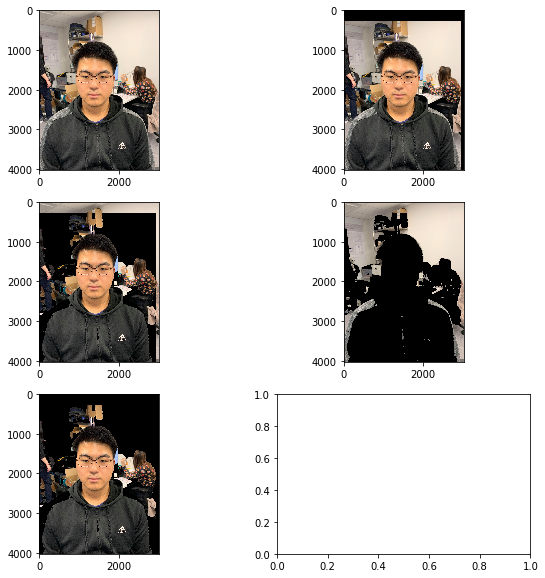

In [123]:
np.unique(mask) # 0 - sure forground, 2- maybe fg, 3- background
img_color =  cv.imread('./ply/albert.jpg')
img_color = np.flip(img_color,axis=2)

mask1 = np.where((mask==0),0,1).astype('uint8')
mask2 = np.where((mask==2),0,1).astype('uint8')
mask3 = np.where((mask==3),0,1).astype('uint8')
mask4 = np.where(((mask==2) | (mask==0)),0,1).astype('uint8')


f, axarr = plt.subplots(3,2, figsize=(10,10))
axarr[0,0].imshow(img_color)
axarr[0,1].imshow(img_color * mask1[:,:,np.newaxis])
axarr[1,0].imshow(img_color * mask2[:,:,np.newaxis])
axarr[1,1].imshow(img_color * mask3[:,:,np.newaxis])
axarr[2,0].imshow(img_color * mask4[:,:,np.newaxis])



# IF YOU ARE HERE FROM INTRO ML 
# STOP HERE. 
 
or keep looking, the rest of the this stuff isnt needed for intro ML. did it for funsies. 

## Now that I have some nice masks, lets get th foreground and background to move separately

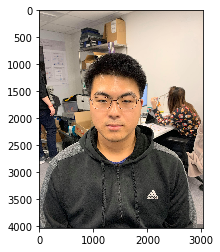

In [133]:
plt.imshow((img_color *( mask3[:,:,np.newaxis]+ mask4[:,:,np.newaxis])))

In [207]:
fg_pxs = img * mask4[:,:,np.newaxis]
bg_pxs = img * mask3[:,:,np.newaxis]

for i in range(-10, 10):
#     n = int(fg_pxs.shape[1]/100) * i
    n = 5 * i
    move_n_x = np.roll(fg_pxs, shift=n, axis=1)
    new_img = np.where(move_n_x == 0, bg_pxs, move_n_x)
    cv.imwrite(f"grabcut_res/albert_series/img{i+10:02d}.jpg", new_img)

## turn this into a bouncy gif and display it

In [ ]:
!{'ffmpeg -r 5 -i grabcut_res/albert_series/img%02d.jpg grabcut_res/albert_series/test.mp4'}
!{'ffmpeg -i grabcut_res/albert_series/test.mp4 -filter_complex "[0]reverse[r];[0][r]concat,loop=5:250,setpts=N/25/TB" grabcut_res/albert_series/output.mp4'}
!{'ffmpeg -i grabcut_res/albert_series/output.mp4 -f gif grabcut_res/albert_series/output.gif'}

In [211]:
from IPython.display import HTML
HTML('<img width=300px src="grabcut_res/albert_series/output.gif">')

In [1]:
plt.imshow(bg_pxs = img * mask3[:,:,np.newaxis])

NameError: name 'plt' is not defined